## Processing

In [15]:
from datetime import datetime, date
import os
import warnings

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
import pandas as pd
import pennylane as qml
from pennylane import qaoa
import sympy as sp

from qaoa_solver import QAOASolver
from utils import compute_solution, compute_fidelity, get_pennylane_layer, int_to_binary_str


pd.set_option('display.max_columns', None)

ticks_formatter = FuncFormatter(lambda x, _: f"${x:g}$")

In [ ]:
experiment_names = os.listdir('experiments/results')
experiment_names = [name for name in experiment_names if not name.startswith('test')]
experiment_results = []

for experiment in experiment_names:

    experiment_result_files = os.listdir(f'experiments/results/{experiment}')
    
    for result_file in experiment_result_files:
        result_date = datetime.strptime(result_file.split('_')[-1].split('.json')[0], '%Y%m%d%H%M%S%f').date()
        result = pd.read_json(f'experiments/results/{experiment}/{result_file}',lines=True)
        result['date'] = result_date
        result['filepath'] = result_file
        experiment_results.append(result)


experiment_results = pd.concat(experiment_results)
experiment_results['num_qubits'] = experiment_results['nx'] + experiment_results['ny']
experiment_results['optimizer'] = experiment_results['config'].apply(lambda c: c.get('optimizer'))
experiment_results['problem_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('problem_hamiltonian'))
experiment_results['cost_hamiltonian'] = experiment_results['config'].apply(lambda c: c.get('cost_hamiltonian'))
experiment_results['gamma_0'] = experiment_results['config'].apply(lambda c: c.get('initial_gamma'))
experiment_results['beta_0'] = experiment_results['config'].apply(lambda c: c.get('initial_beta'))
experiment_results['experiment'] = experiment_results['config'].apply(lambda c: c.get('experiment'))
experiment_results['extended_qaoa'] = experiment_results['config'].apply(lambda c: c.get('extended_qaoa', False))
experiment_results['max_layers'] = experiment_results['config'].apply(lambda c: c.get('layers'))
experiment_results['commit_date'] = pd.to_datetime(experiment_results['config'].apply(lambda c: c.get('commit_date')))
experiment_results['setup'] = experiment_results['experiment'].str.split('_').str[1:].str.join('_')
experiment_results['state'] = experiment_results['state'].apply(lambda st: np.array([complex(c) for c in st]))
experiment_results['populations'] = experiment_results['state'].apply(lambda s: [abs(complex(c))**2 for c in s])
experiment_results['solution'] = experiment_results.apply(lambda row: compute_solution(row['N']), axis=1)
experiment_results['no_solutions'] = experiment_results['solution'].apply(lambda sols: len(sols))
experiment_results['fidelity'] = experiment_results.apply(lambda row: compute_fidelity(row['populations'], row['solution']), axis=1)

experiment_results = experiment_results[(experiment_results['extended_qaoa']==False)]
experiment_results = experiment_results[experiment_results['date'] < date(2025,9,29)]

Ns = sorted(experiment_results['N'].unique())
problem_Hs = sorted(experiment_results['problem_hamiltonian'].unique())
cost_Hs = sorted(experiment_results['cost_hamiltonian'].unique())

dfs = []
for N in Ns:
    for Hc in cost_Hs:
        solver = QAOASolver(N=N, cost_hamiltonian=Hc)
        Ec = np.array([E.real for E in solver.Ec])
        df = pd.DataFrame({
            'N': [N],
            'cost_hamiltonian': [Hc],
            'Ec': [Ec]
        })
        dfs.append(df)
energies_cost_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_cost_df, how='left', on=['N', 'cost_hamiltonian'])
experiment_results['Ec_max'] = experiment_results['Ec'].apply(lambda E: np.max(E)) #Ec's are positive

dfs = []
for N in Ns:
    for Hp in problem_Hs:
        solver = QAOASolver(N=N, problem_hamiltonian=Hp)
        Ep = np.array([E.real for E in solver.Ep])
        df = pd.DataFrame({
            'N': [N],
            'problem_hamiltonian': [Hp],
            'Ep': [Ep]
        })
        dfs.append(df)
energies_prob_df = pd.concat(dfs, ignore_index=True)

experiment_results = experiment_results.merge(energies_prob_df, how='left', on=['N', 'problem_hamiltonian'])
experiment_results['Ep_max'] = experiment_results['Ep'].apply(lambda E: np.max(np.abs(E))) #Ep's can be negative
experiment_results['signed_normalized_Ep'] = experiment_results['Ep'] / experiment_results['Ep_max']
experiment_results['normalized_Ep'] = experiment_results['Ep'].apply(np.abs) / experiment_results['Ep_max']

# Computing H_QP cost in linear_abs protocol -- Normalized cost to compare between different protocols and N's
quadratic_energies = energies_cost_df[energies_cost_df['cost_hamiltonian']=='quadratic_H'][['N', 'Ec']]
quadratic_energies = quadratic_energies.rename(columns={'Ec': 'quadratic_Ec'})
experiment_results = experiment_results.merge(quadratic_energies, how='left', on='N')
experiment_results['normalized_cost'] = experiment_results.apply(
    lambda row: np.vdot(row['state'], row['quadratic_Ec'] * row['state']).real
        if row['cost_hamiltonian']=='abs_H'
        else row['cost'], axis=1)

# Relative cost: Cost with respect to the maximum cost (normally the achieved using one layer)
max_costs = experiment_results.groupby(['N', 'optimizer', 'setup'])['normalized_cost'].max().reset_index()
max_costs = max_costs.rename(columns={'normalized_cost': 'max_cost'})
experiment_results = experiment_results.merge(max_costs, how='left', on=['N', 'optimizer', 'setup'])
experiment_results['relative_cost'] = experiment_results['normalized_cost'] / experiment_results['max_cost']

dfs = []
for N, nx, ny in experiment_results[['N', 'nx', 'ny']].drop_duplicates().sort_values('N').itertuples(index=False):
    for Hp in problem_Hs:
        gate_sizes = dict(qml.specs(get_pennylane_layer(N, nx, ny, Hp), level=None)()['resources'].gate_sizes)
        dfs.append(pd.DataFrame({'N': [N], 'problem_hamiltonian': [Hp], 'gate_sizes': [gate_sizes]}))
gates_df = pd.concat(dfs, ignore_index=True)
experiment_results = experiment_results.merge(gates_df, how='left', on=['N', 'problem_hamiltonian'])

experiment_results['num_2qub_gates_layer'] = experiment_results['gate_sizes'].apply(lambda s: s[2]*2 + s.get(3,0)*4 + s.get(4,0)*6)
experiment_results['num_2qub_gates'] = experiment_results.apply(lambda row: row['num_2qub_gates_layer']*row['layers'], axis=1)

In [8]:
# Plotting

markers = ['o', "s", "D", "p", "v", "^", "X", "<", ">", "H","o", "s", "D", "p", "v", "^", "X", "<", ">", "H"]

plot_colors = [
    #[Dark ,    light]
    ["#000000",   "#A0A0A0"],  # Black
    ["#004C99", "#99CCFF"],  # Blue
    ["#990000", "#FF9999"],  # Red
    ["#006633", "#CCFFCC"],  # Green
    ["#b8860b", "#ffd700"],  # Golden
    ["#cc4c02", "#fe9929"],  # Orange
    ["#a10694", "#c994c7"],  # Purple
    ["#0868ac", "#43a2ca"],  # Cian
    ["#8c510a", "#d8b365"],  # Brown
    ["#6a3d9a", "#cab2d6"],  # Violet
    ["#1b9e77", "#a6dba0"],  # Teal-green
    ["#d95f02", "#fdb863"],  # Deep orange
    ["#7570b3", "#b3cde3"],  # Indigo
    ["#e7298a", "#fbb4b9"],  # Magenta-pink
    ["#66a61e", "#c2e699"],  # Olive-green
]


rc('font', family='Times New Roman', size=16)
rc('mathtext', fontset='cm')
rc('lines', linewidth=4, markersize=8, markeredgewidth=1.5)
rc('axes', labelsize=14, titlesize=16)
rc('legend', fontsize=14, title_fontsize=14)
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

## Figure 1

Circuit ansatz for N=25. Quadratic & Linearized.

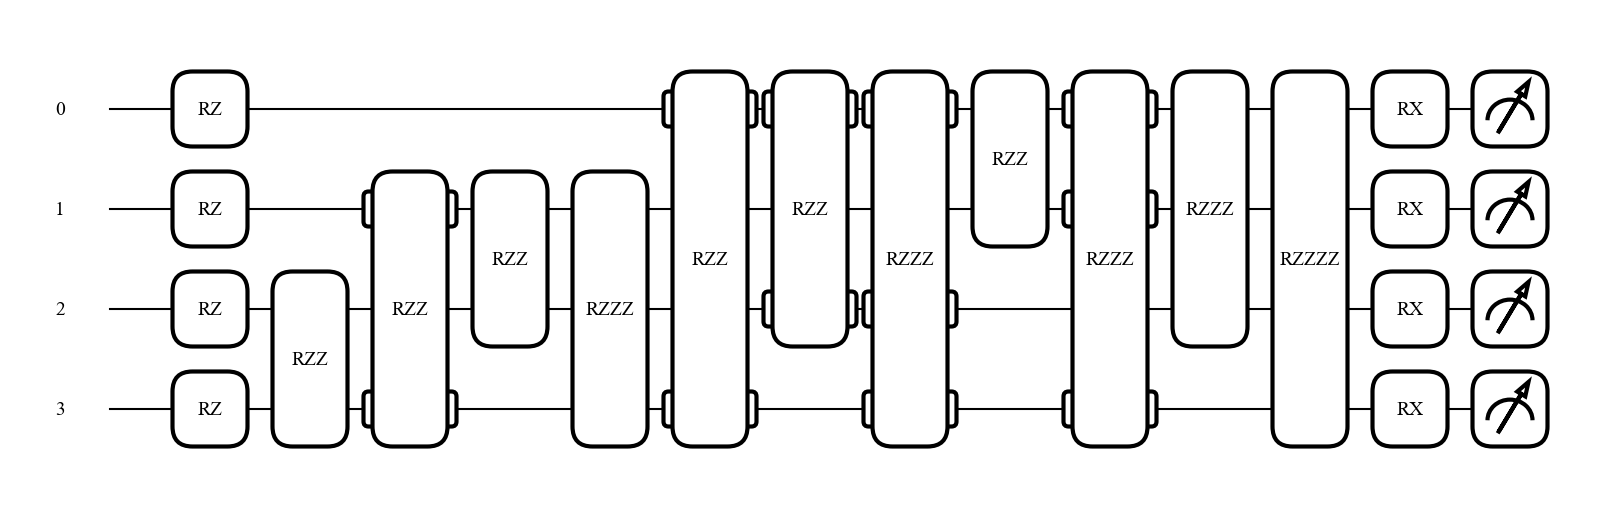

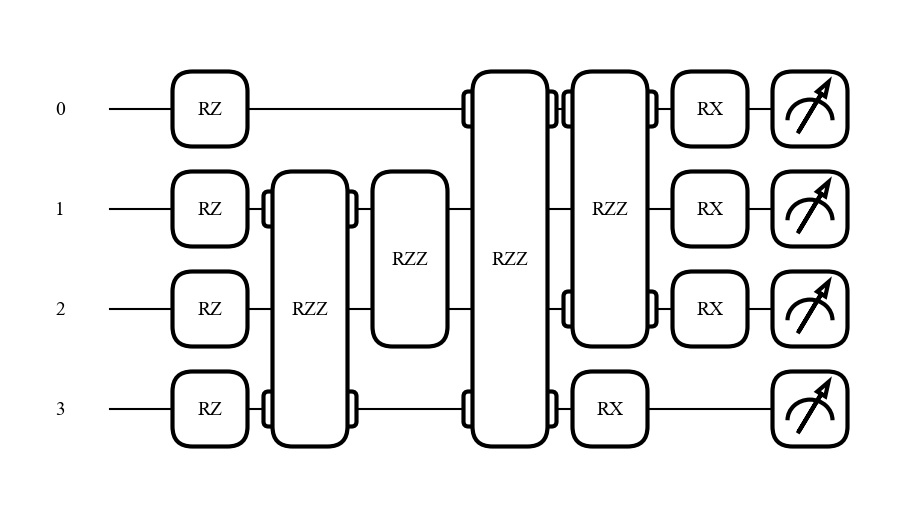

In [9]:
N = 25

solver = QAOASolver(N, layers=1)

layer_quadratic = get_pennylane_layer(N, solver.nx, solver.ny, 'quadratic_H')
layer_linear = get_pennylane_layer(N, solver.nx, solver.ny, 'linear_H')

qml.draw_mpl(layer_quadratic, level=None)()
plt.savefig('plots/paper/circuit_25_quadratic.pdf', format='pdf', bbox_inches='tight')

qml.draw_mpl(layer_linear, level=None)()
plt.savefig('plots/paper/circuit_25_linear.pdf', format='pdf', bbox_inches='tight')

## Figure 2

Summarize the performance by creating graphs of some quantities X as function of the number factorized N, where we pick the values of each quantity only in the last block.

### Cost function

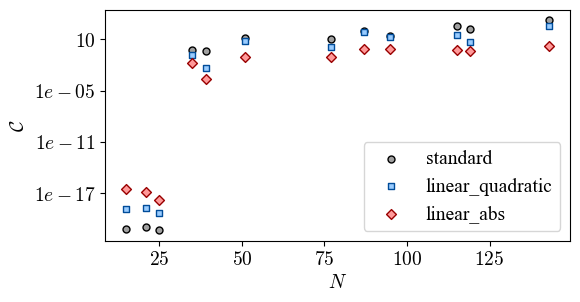

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.subplots_adjust(hspace=0.4)

df = experiment_results[(experiment_results['optimizer']=='BFGS')]
max_layers = df.groupby(['N','setup'])['layers'].max().reset_index().groupby('N')['layers'].min().reset_index()

df = df.merge(max_layers, how='inner', on=['N', 'layers'])

for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
    df_prot = df[(df['setup']==protocol)].copy()
    ax.scatter(
        'N', 'cost', data=df_prot, label=protocol,
        color=plot_colors[j][0],
        marker=markers[j], s=25, linewidth=1,
        ec=plot_colors[j][0], fc=plot_colors[j][1]
    )

ax.set_xlabel('$N$')
ax.set_yscale('log')
ax.set_ylabel('$\mathcal{C}$')

ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)

ax.legend();

plt.savefig('plots/paper/summary_cost.pdf', format='pdf', bbox_inches='tight')

### Fidelity

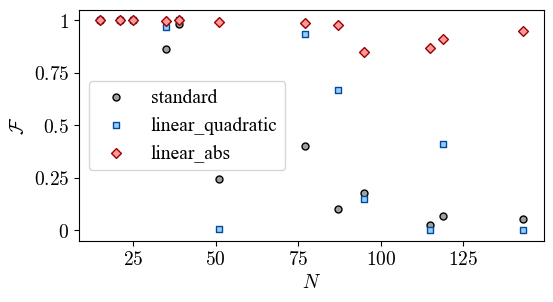

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.subplots_adjust(hspace=0.4)

df = experiment_results[(experiment_results['optimizer']=='BFGS')]
max_layers = df.groupby(['N','setup'])['layers'].max().reset_index().groupby('N')['layers'].min().reset_index()

df = df.merge(max_layers, how='inner', on=['N', 'layers'])

for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
    df_prot = df[(df['setup']==protocol)].copy()
    ax.scatter(
        'N', 'fidelity', data=df_prot, label=protocol,
        color=plot_colors[j][0],
        marker=markers[j], s=25, linewidth=1,
        ec=plot_colors[j][0], fc=plot_colors[j][1]
    )

ax.set_xlabel('$N$')
ax.set_ylabel('$\mathcal{F}$')

ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)

ax.legend();

plt.savefig('plots/paper/summary_fidelity.pdf', format='pdf', bbox_inches='tight')

### Number of two-qubit gates for one-layer circuits

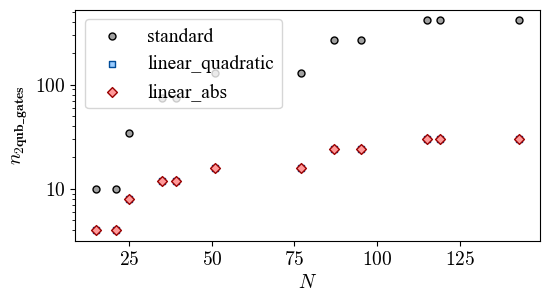

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.subplots_adjust(hspace=0.4)

df = experiment_results[(experiment_results['optimizer']=='BFGS') & (experiment_results['layers']==1)]

for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
    df_prot = df[(df['setup']==protocol)].copy()
    ax.scatter(
        'N', 'num_2qub_gates', data=df_prot, label=protocol,
        color=plot_colors[j][0],
        marker=markers[j], s=25, linewidth=1,
        ec=plot_colors[j][0], fc=plot_colors[j][1]
    )

ax.set_xlabel('$N$')
ax.set_ylabel('$n_\mathbf{2qub\_gates}$')
ax.set_yscale('log')

ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)

ax.legend();

plt.savefig('plots/paper/summary_num2qubgates.pdf', format='pdf', bbox_inches='tight')

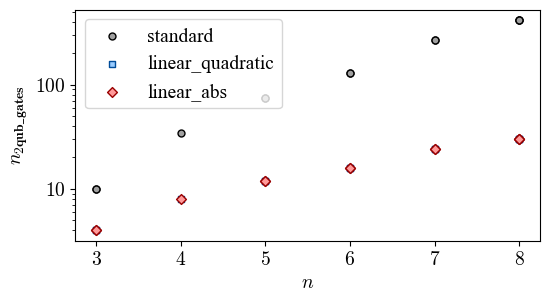

In [13]:
# Or versus the problem size

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.subplots_adjust(hspace=0.4)

df = experiment_results[(experiment_results['optimizer']=='BFGS') & (experiment_results['layers']==1)]

for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
    df_prot = df[(df['setup']==protocol)].copy()
    ax.scatter(
        'num_qubits', 'num_2qub_gates', data=df_prot, label=protocol,
        color=plot_colors[j][0],
        marker=markers[j], s=25, linewidth=1,
        ec=plot_colors[j][0], fc=plot_colors[j][1]
    )

ax.set_xlabel('$n$')
ax.set_ylabel('$n_\mathbf{2qub\_gates}$')
ax.set_yscale('log')

ax.xaxis.set_major_formatter(ticks_formatter)
ax.yaxis.set_major_formatter(ticks_formatter)

ax.legend();

## Figure 3

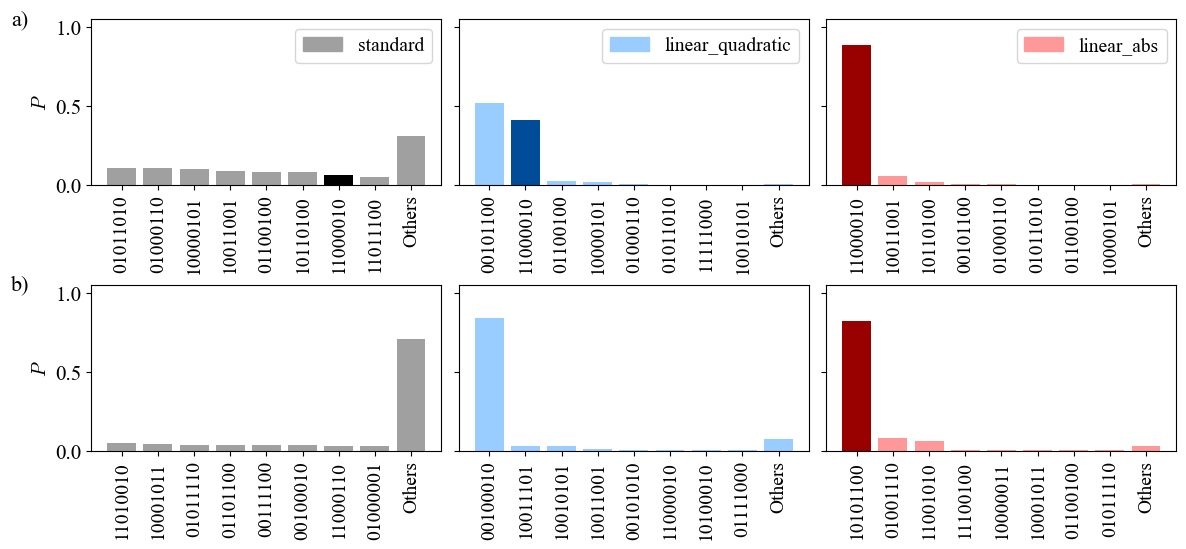

In [14]:
Ns = [119, 143]

ncols = 3
nrows = len(Ns)

fig, axs = plt.subplots(nrows, ncols, figsize=(14, 2.8*nrows), sharey=True)
fig.subplots_adjust(hspace=0.6, wspace=0.05)

for i, N in enumerate(Ns):
    for j, protocol in enumerate(['standard','linear_quadratic','linear_abs']):
        ax = axs[i][j]
        df_N = experiment_results[(experiment_results['N']==N)
                        & (experiment_results['optimizer']=='BFGS')]
        max_layers = df_N[df_N['fidelity']>=0.8].sort_values('layers', ascending=True) \
            .reset_index().loc[0,'layers']
        df = df_N[(df_N['layers']==max_layers) & (df_N['setup']==protocol)].reset_index()
        
        probs = np.array(df.loc[0, 'populations'])
        num_qubits = df.loc[0, 'num_qubits']
        solutions = df.loc[0, 'solution']
        x_hist = [int_to_binary_str(n, num_qubits) for n in range(2**num_qubits)]
        idx_sorted = np.argsort(probs)[::-1]
        
        # Select top 8
        top_k = 8
        idx_top = idx_sorted[:top_k]
        idx_rest = idx_sorted[top_k:]
        
        # Build reduced x and y
        x_top = [x_hist[k] for k in idx_top]
        y_top = probs[idx_top]
        
        # Add the "Others" bar
        x_plot = x_top + ['Others']
        y_plot = list(y_top) + [probs[idx_rest].sum()]
        
        # Colors: dark if solution, light otherwise, gray for "Others"
        bar_colors = [
            plot_colors[j][0] if label in solutions else plot_colors[j][1]
            for label in x_top
        ] + [plot_colors[j][1]]  # gray for "Others"

        ax.bar(x_plot, y_plot, color=bar_colors, label=protocol)
        ax.xaxis.set_tick_params(rotation=90, labelsize=14)
        ax.yaxis.set_tick_params(labelsize=15)
        ax.set_ylim(0,1.05)
        if j==0:
            ax.set_ylabel('$P$')

        if i==0:
            light_patch = Patch(color=plot_colors[j][1], label=protocol)
            ax.legend(handles=[light_patch])

row_labels = ['a)', 'b)']
for i, label in enumerate(row_labels):
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.18, 1, label, transform=ax.transAxes,
            fontsize=16, va='center', ha='right', fontfamily='Times New Roman')

plt.savefig(f"plots/paper/populations_{''.join([str(N) for N in Ns])}.pdf", format='pdf', bbox_inches='tight')


## Figure 4

### Spectrum plot

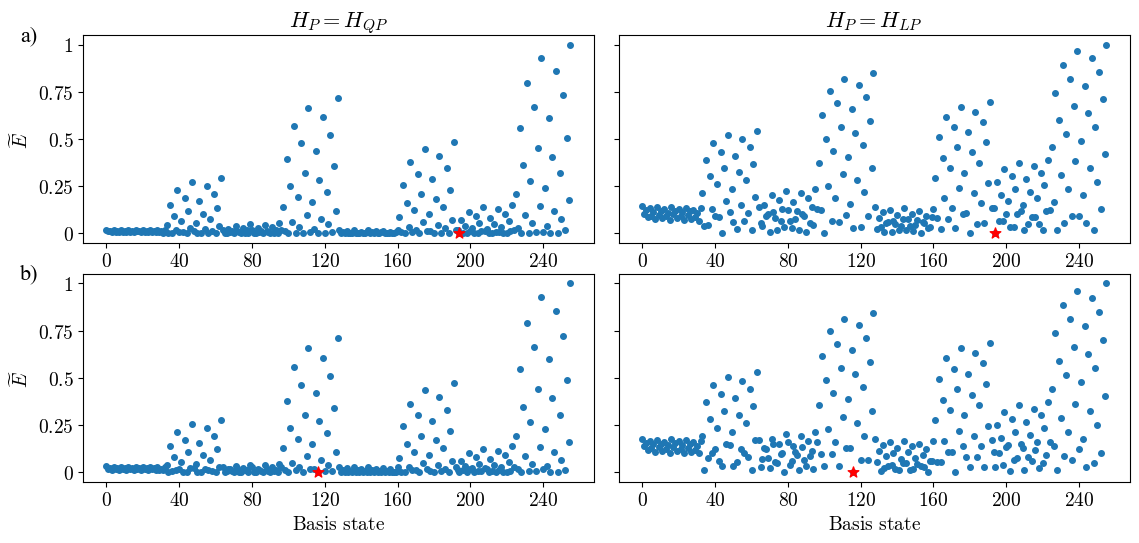

In [18]:
Ns = [119, 143]

fig, axs = plt.subplots(len(Ns), 2, figsize=(13.5,2.9*len(Ns)), sharey=True)
fig.subplots_adjust(wspace=0.05, hspace=0.15)

for i, N in enumerate(Ns):
    for j, setup in enumerate(['standard', 'linear_quadratic']):
        ax = axs[i][j]
        df = experiment_results[(experiment_results['N']==N)
                                &(experiment_results['setup']==setup)
                                & (experiment_results['optimizer']=='BFGS')].reset_index()
        Ep = df.loc[0,'Ep']
        R = np.max(np.abs(Ep))
        normalized_Ep = np.abs(Ep)/R
        title = f'$H_P=H_{{{"Q" if setup=="standard" else "L"}P}}$'
        ax.scatter(range(len(Ep)), normalized_Ep, s=16)

        sol = list(normalized_Ep).index(0)
        ax.scatter(sol, 0, s=64, color='red', marker='*')

        if i==0:
            ax.set_title(title)
        if j==0:
            ax.set_ylabel('$\\widetilde{E}$')
        if i==len(Ns)-1:
            ax.set_xlabel('$\\text{Basis state}$')

        ax.xaxis.set_major_formatter(ticks_formatter)
        ax.yaxis.set_major_formatter(ticks_formatter)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=np.log2(len(Ep)), integer=True))

row_labels = ['a)', 'b)']
for i, label in enumerate(row_labels):
    ax = axs[i, 0]  # first column of each row
    ax.text(-0.09, 1, label, transform=ax.transAxes,
            fontsize=16, va='center', ha='right', fontfamily='Times New Roman')

plt.savefig(f"plots/paper/energy_spectrums.pdf", format='pdf', bbox_inches='tight')

### Compute cDOS

We define the density of states as $\rho_H = \dfrac{\mathcal{N}(E_0)}{\mathrm{dim} H}$, where $\mathcal{N}(E_0)$ is the
number of states with energy $|E| < E_0$, and $E_0$ is the mean energy of $H_\mathrm{QP}$.

In [73]:
df = experiment_results[(experiment_results['N'].isin([119,143]))
                        &(experiment_results['setup'].isin(['standard','linear_quadratic']))
                        & (experiment_results['optimizer']=='BFGS')
                        & (experiment_results['layers']==1)].reset_index()

df['dim'] = np.pow(2, df['num_qubits'])
df = df[['N', 'dim', 'setup', 'normalized_Ep']].sort_values(['N','setup'], ascending=[True,False])

# We calculate the mean energy ONLY for standard (quadratic) Hamiltonian
mean_energy = df[df['setup']=='standard'].copy()
mean_energy['mean_normalized_Ep'] = mean_energy['normalized_Ep'].apply(np.mean)
mean_energy = mean_energy[['N', 'mean_normalized_Ep']]

df = df.merge(mean_energy, how='left', on='N')

# Count the number of states below the mean
df['num_states'] = df.apply(lambda row: len(list(filter(lambda e: e < row['mean_normalized_Ep'], row['normalized_Ep']))), axis=1)

# Compute cDOS
df['cDOS'] = df['num_states'] / df['dim']

In [74]:
df.head()

,N,dim,setup,normalized_Ep,mean_normalized_Ep,num_states,cDOS
0,119,256,standard,"[0.02040816326530612, 0.010840187841870446, 0....",0.101510,189,0.738281
1,119,256,linear_quadratic,"[0.14285714285714285, 0.10411622276029056, 0.1...",0.101510,96,0.375000
2,143,256,standard,"[0.03134930752918203, 0.018812072064228455, 0....",0.098348,192,0.750000
3,143,256,linear_quadratic,"[0.1770573566084788, 0.1371571072319202, 0.157...",0.098348,75,0.292969
